In [1]:
import os, glob, sys, io
from pathlib import Path

from pprint import pprint
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import scipy
import scipy.signal
import scipy.interpolate
import cupy as cp

import ismrmrd
import ismrmrd.xsd

from tqdm.auto import tqdm, trange


from IPython.core.display import display, HTML

In [2]:
import pandas as pd
data_dir = r'H:\Dataset\Bio\MRI Reconstruction\mridata'
tables = pd.read_csv('mridata.csv')
tables

,UUID,Downloads,References,Comments,Funding Support,Protocol Name,Series Description,System Vendor,System Model,System Field Strength,...,Number of Contrasts,Trajectory,Parallel Imaging Factor,Repetition Time,Echo Time,Inversion Time,Flip Angle,Sequence Type,Echo Spacing,Upload Date
0,413469fd-9354-400c-88e3-b29e7c711a05,2153,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,SAG,SAG,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2800 ms,22 ms,100 ms,150 °,TurboSpinEcho,11.12 ms,"Aug. 8, 2018, 7:12 a.m."
1,6a8fff64-9bba-4ce7-aa58-d024214b4d7a,4757,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,SAG,SAG,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2800 ms,22 ms,100 ms,150 °,TurboSpinEcho,11.12 ms,"Aug. 8, 2018, 7:12 a.m."
2,bd01dd30-46e7-4415-bf04-ed4cc6ac2b64,1162,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,SAG,SAG,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2800 ms,22 ms,100 ms,150 °,TurboSpinEcho,11.12 ms,"Aug. 8, 2018, 7:11 a.m."
3,6493682f-c9d3-44a7-8c0f-7fdf8b165410,1090,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,SAG,SAG,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2800 ms,22 ms,100 ms,150 °,TurboSpinEcho,11.12 ms,"Aug. 8, 2018, 7:10 a.m."
4,48c95dcf-c074-499b-a63c-74f0bf7dff1f,1141,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,SAG,SAG,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2800 ms,22 ms,100 ms,150 °,TurboSpinEcho,11.12 ms,"Aug. 8, 2018, 7:09 a.m."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,a5d10e70-627b-4a4c-943b-0639fd2cee8d,385,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,COR,COR,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,3170 ms,33 ms,100 ms,180 °,TurboSpinEcho,10.96 ms,"Aug. 6, 2018, 12:16 p.m."
96,9616b2e4-81fc-4bd5-bee0-e3aac05cd0a5,383,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,COR,COR,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2870 ms,33 ms,100 ms,180 °,TurboSpinEcho,10.96 ms,"Aug. 6, 2018, 12:14 p.m."
97,4ed55066-656a-46aa-af95-81667b4f565b,381,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,COR,COR,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2870 ms,33 ms,100 ms,180 °,TurboSpinEcho,10.96 ms,"Aug. 6, 2018, 12:12 p.m."
98,be92c2de-4b73-4f07-a081-73973bf5d037,385,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,COR,COR,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,3010 ms,33 ms,100 ms,180 °,TurboSpinEcho,10.96 ms,"Aug. 6, 2018, 12:10 p.m."


In [3]:
def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions

    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = cp.fft.fftshift(cp.fft.ifftn(cp.fft.ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    return img



def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions

    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = cp.fft.fftshift(cp.fft.fftn(cp.fft.ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    return k


In [4]:
def convert_ismrmrd_to_cupy_array(filename):
    # Load file
    if not os.path.isfile(filename):
        print("%s is not a valid file" % filename)
        raise SystemExit
    dset = ismrmrd.Dataset(filename, 'dataset', create_if_needed=False)

    header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
    enc = header.encoding[0]

    # Matrix size
    eNx = enc.encodedSpace.matrixSize.x
    eNy = enc.encodedSpace.matrixSize.y
    eNz = enc.encodedSpace.matrixSize.z
    rNx = enc.reconSpace.matrixSize.x
    rNy = enc.reconSpace.matrixSize.y
    rNz = enc.reconSpace.matrixSize.z

    # Field of View
    eFOVx = enc.encodedSpace.fieldOfView_mm.x
    eFOVy = enc.encodedSpace.fieldOfView_mm.y
    eFOVz = enc.encodedSpace.fieldOfView_mm.z
    rFOVx = enc.reconSpace.fieldOfView_mm.x
    rFOVy = enc.reconSpace.fieldOfView_mm.y
    rFOVz = enc.reconSpace.fieldOfView_mm.z

    lNx = rNx
    lNy = enc.encodingLimits.kspace_encoding_step_1.maximum + 1
    lNz = enc.encodingLimits.kspace_encoding_step_2.maximum + 1

    # Number of Slices, Reps, Contrasts, etc.
    ncoils = header.acquisitionSystemInformation.receiverChannels
    if enc.encodingLimits.slice != None:
        nslices = enc.encodingLimits.slice.maximum + 1
    else:
        nslices = 1


    if enc.encodingLimits.repetition != None:
        nreps = enc.encodingLimits.repetition.maximum + 1
    else:
        nreps = 1

    if enc.encodingLimits.contrast != None:
        ncontrasts = enc.encodingLimits.contrast.maximum + 1
    else:
        ncontrasts = 1


    # TODO loop through the acquisitions looking for noise scans
    firstacq=0
    for acqnum in range(dset.number_of_acquisitions()):
        acq = dset.read_acquisition(acqnum)

        # TODO: Currently ignoring noise scans
        if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
#             print("Found noise scan at acq ", acqnum)
            continue
        else:
            firstacq = acqnum
#             print("Imaging acquisition starts acq ", acqnum)
            break




    remove_oversampling_x = True

    # Initialiaze a storage array
    all_data = cp.zeros((nreps, ncontrasts, nslices, ncoils, lNz, lNy, rNx if remove_oversampling_x else eNx), 
                        dtype=cp.complex64)

    # Loop through the rest of the acquisitions and stuff
    for acqnum in trange(firstacq,dset.number_of_acquisitions()):
        acq = dset.read_acquisition(acqnum)
        data = cp.asarray(acq.data)
        # TODO: this is where we would apply noise pre-whitening

        # Remove oversampling if needed
        if remove_oversampling_x and eNx != rNx:
            xline = transform_kspace_to_image(data, [1])
            x0 = (eNx - rNx) // 2
            x1 = (eNx - rNx) // 2 + rNx
            xline = xline[:,x0:x1]
            acq.resize(rNx,acq.active_channels,acq.trajectory_dimensions)
            acq.center_sample = rNx//2
            # need to use the [:] notation here to fill the data
            data = transform_image_to_kspace(xline, [1])

        # Stuff into the buffer
        rep = acq.idx.repetition
        contrast = acq.idx.contrast
        slice = acq.idx.slice
        y = acq.idx.kspace_encode_step_1
        z = acq.idx.kspace_encode_step_2
        all_data[rep, contrast, slice, :, z, y, :] = data

    info = dict(lNx=lNx, lNy=lNy, lNz=lNz,
                eNx=eNx, eNy=eNy, eNz=eNz,
                rNx=rNx, rNy=rNy, rNz=rNz,
                eFOVx=eFOVx, eFOVy=eFOVy, eFOVz=eFOVz,
                rFOVx=rFOVx, rFOVy=rFOVy, rFOVz=rFOVz,
                ncoils=ncoils, nslices=nslices, nreps=nreps, ncontrasts=ncontrasts)
    return all_data, info

In [9]:
out_dir = "F:/MohammadRaziei/project/Dataset/ismrmrd_to_npz"

uuid = tables.iloc[0]['UUID']
filename = os.path.join(data_dir, uuid+".h5")

all_data, info = convert_ismrmrd_to_cupy_array(filename)
np.savez(os.path.join(out_dir, "%s.npz"%uuid), kspace=all_data.get(), info = info)

In [10]:
import scipy, os
import numpy as np

out_dir = "F:/MohammadRaziei/project/Dataset/ismrmrd_to_npz"
uuid = tables.iloc[0]['UUID']
filename = os.path.join(data_dir, uuid+".h5")

source = np.load(os.path.join(out_dir, "%s.npz"%uuid), allow_pickle=True)
data_all = source['kspace']
info = source['info']
data_all.shape

(1, 1, 31, 15, 1, 616, 384)

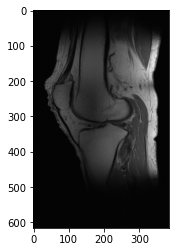

Wall time: 2.1 s


In [16]:
%%time
data_orig = np.squeeze(data_all)
images = np.fft.fftshift(scipy.fft.fft2(data_orig, workers=os.cpu_count()))
im = np.sqrt(np.sum(images**2,1))
plt.imshow(np.abs(im[5]), cmap='gray')
plt.show()

In [7]:
out_dir = "F:/MohammadRaziei/project/Dataset/ismrmrd_to_npz"
filenames = glob.glob(data_dir+"/*h5")

for i, filename in enumerate(filenames): 
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    cp.fft.config.get_plan_cache().clear()

    uuid = Path(filename).stem
    print("\n[{:03.0f}%]>> process on '{}'".format(100*(i+1)/len(filenames),uuid))
    all_data, info = convert_ismrmrd_to_cupy_array(filename)
    np.savez(os.path.join(out_dir, "%s.npz"%uuid), kspace=all_data.get(), info = info, allow_pickle=True)
#     all_data, info = convert_ismrmrd_to_cupy_array(filename)
#     np.savez(os.path.join(out_dir, "%s.npz"%uuid), kspace=all_data.get(), info = info)


[002%]>> process on '14b0b5bd-25f4-4e6c-aa50-5a0048a495f8'


  0%|          | 0/14652 [00:00<?, ?it/s]


[004%]>> process on '18fe726f-1085-4c93-989b-0f79f084fbe4'


  0%|          | 0/19220 [00:00<?, ?it/s]


[006%]>> process on '2448503f-4fda-4e3e-b269-bfffa814962d'


  0%|          | 0/15048 [00:00<?, ?it/s]


[008%]>> process on '31040ec1-2c09-4b2d-b772-1079d262cc87'


  0%|          | 0/28006 [00:00<?, ?it/s]


[010%]>> process on '34c9860c-c752-4062-aaf5-530d63272c98'


  0%|          | 0/15840 [00:00<?, ?it/s]


[012%]>> process on '36cb711d-5a2d-449a-b381-ab01c913055e'


  0%|          | 0/15048 [00:00<?, ?it/s]


[014%]>> process on '36ddbca0-c5fd-41a3-854d-4790649d89c2'


  0%|          | 0/30788 [00:00<?, ?it/s]


[016%]>> process on '3806b119-5c9b-4ea4-bf53-bb3b6706149b'


  0%|          | 0/14256 [00:00<?, ?it/s]


[018%]>> process on '3b2f97c1-6c7a-41b7-82bb-698f0b6fd3d0'


  0%|          | 0/35050 [00:00<?, ?it/s]


[020%]>> process on '3c8b5e73-29ab-400d-b397-5f0bca4b7cb6'


  0%|          | 0/15444 [00:00<?, ?it/s]


[022%]>> process on '413469fd-9354-400c-88e3-b29e7c711a05'


  0%|          | 0/21279 [00:00<?, ?it/s]


[024%]>> process on '413d7d8f-4644-4bef-86e2-89f01cd84215'


  0%|          | 0/35097 [00:00<?, ?it/s]


[026%]>> process on '47a37b36-d970-47b4-ac8c-3b2c8d50d002'


  0%|          | 0/16236 [00:00<?, ?it/s]


[028%]>> process on '48c95dcf-c074-499b-a63c-74f0bf7dff1f'


  0%|          | 0/19840 [00:00<?, ?it/s]


[030%]>> process on '4b2f85dd-ee7b-485a-b1d9-9ba569adea07'


  0%|          | 0/15048 [00:00<?, ?it/s]


[032%]>> process on '4be8d222-d941-4da5-97cf-c9b04dd8b50e'


  0%|          | 0/17952 [00:00<?, ?it/s]


[034%]>> process on '4d080529-72a2-4004-a6cb-7f84c5455c98'


  0%|          | 0/13068 [00:00<?, ?it/s]


[036%]>> process on '516288da-d22b-4e92-9282-96665134c84a'


  0%|          | 0/19840 [00:00<?, ?it/s]


[038%]>> process on '60f071c4-438f-42b7-b06b-cebfae19f3a1'


  0%|          | 0/13068 [00:00<?, ?it/s]


[040%]>> process on '6493682f-c9d3-44a7-8c0f-7fdf8b165410'


  0%|          | 0/20460 [00:00<?, ?it/s]


[042%]>> process on '6a8fff64-9bba-4ce7-aa58-d024214b4d7a'


  0%|          | 0/19220 [00:00<?, ?it/s]


[044%]>> process on '7953af76-63f4-4b64-984a-adbc67ade280'


  0%|          | 0/36568 [00:00<?, ?it/s]


[046%]>> process on '826bba6e-8dd3-4b41-a689-c0b2138294db'


  0%|          | 0/13860 [00:00<?, ?it/s]


[048%]>> process on '88fa0347-619f-4d6e-b0a6-d243f06ce163'


  0%|          | 0/16368 [00:00<?, ?it/s]


[050%]>> process on '8ed409e6-538d-490f-bad6-6929ad1e9151'


  0%|          | 0/13464 [00:00<?, ?it/s]


[052%]>> process on '8fc09359-0ea0-4b14-b636-e1d34cc971df'


  0%|          | 0/21120 [00:00<?, ?it/s]


[054%]>> process on '905567b1-7ea2-4272-96cd-ec9acf195554'


  0%|          | 0/15048 [00:00<?, ?it/s]


[056%]>> process on '907e4462-c45d-4a62-8ade-553f2c217312'


  0%|          | 0/41269 [00:00<?, ?it/s]


[058%]>> process on '90bc0b15-eea2-4abb-b0d2-f3fdad57bb43'


  0%|          | 0/39027 [00:00<?, ?it/s]


[060%]>> process on '936c76f0-b3af-41f0-9b2d-f468f6a71225'


  0%|          | 0/20460 [00:00<?, ?it/s]


[062%]>> process on '95560836-9108-4a9d-89ba-a62ba334043e'


  0%|          | 0/16368 [00:00<?, ?it/s]


[064%]>> process on '9ee7c421-bf8b-42b2-96c9-00ba0f41cf4b'


  0%|          | 0/14256 [00:00<?, ?it/s]


[066%]>> process on 'a48786e2-75f8-4c09-8dcc-a3ee20b9ae81'


  0%|          | 0/19008 [00:00<?, ?it/s]


[068%]>> process on 'a496da39-848a-4fe8-8954-ff63df6785cb'


  0%|          | 0/10044 [00:00<?, ?it/s]


[070%]>> process on 'ac9a60ce-3d72-41c8-a0e7-a29d2022fd86'


  0%|          | 0/13068 [00:00<?, ?it/s]


[072%]>> process on 'af169293-1b83-4bd9-a8cf-4708325cdf73'


  0%|          | 0/32056 [00:00<?, ?it/s]


[074%]>> process on 'b1a090b2-8399-43a4-bf84-c36af47b7e36'


  0%|          | 0/13860 [00:00<?, ?it/s]


[076%]>> process on 'bd01dd30-46e7-4415-bf04-ed4cc6ac2b64'


  0%|          | 0/20460 [00:00<?, ?it/s]


[078%]>> process on 'bde64419-c4c3-4a7f-be23-b38ae6f67454'


  0%|          | 0/18480 [00:00<?, ?it/s]


[080%]>> process on 'c155c00a-80af-421b-ae48-e7ed0dec9777'


  0%|          | 0/15048 [00:00<?, ?it/s]


[082%]>> process on 'c22a01be-8903-4ad3-b58d-3781b2d20bf8'


  0%|          | 0/19220 [00:00<?, ?it/s]


[084%]>> process on 'cafc2ace-a826-4344-8cf9-896ec8bc6120'


  0%|          | 0/20672 [00:00<?, ?it/s]


[086%]>> process on 'cc52722b-8649-45b0-a1ea-8727c1687ad5'


  0%|          | 0/22320 [00:00<?, ?it/s]


[088%]>> process on 'd65e98c1-f893-48b5-b093-057b327a410c'


  0%|          | 0/13860 [00:00<?, ?it/s]


[090%]>> process on 'de6d23d9-b1c4-46af-bc79-ce828f5cd63a'


  0%|          | 0/20460 [00:00<?, ?it/s]


[092%]>> process on 'e3573a0f-34f7-4718-827a-027bf9dd4dea'


  0%|          | 0/8928 [00:00<?, ?it/s]


[094%]>> process on 'e5bea69e-3b5e-44e9-9307-c182b8caf6db'


  0%|          | 0/29029 [00:00<?, ?it/s]


[096%]>> process on 'eef301df-b4d5-4a69-b627-84a324e29631'


  0%|          | 0/19008 [00:00<?, ?it/s]


[098%]>> process on 'fa38d775-b213-4c99-847b-9a9ec9ace97c'


  0%|          | 0/18480 [00:00<?, ?it/s]


[100%]>> process on 'fc58f24a-e6c7-4895-ac6d-60457badaa95'


  0%|          | 0/13068 [00:00<?, ?it/s]